In [1]:
import pandas as pd
import numpy as np
df = pd.read_csv('Pedidos con piezas.csv')
pd.set_option('display.max_columns', None)
df.head(5)

,ID pedido,Det,etie_nomtienda_0,eped_idtipoped_1,Fecha de entrega,Fin de captura,Venta Neta,Sum_Cant piezas
0,28076671,1003,PLAYA DEL CARMEN,11,28/10/2019 12:00,27/10/2019 11:05,832.51,594
1,27504186,1003,PLAYA DEL CARMEN,11,10/09/2019 13:00,6/09/2019 16:57,655.24,503
2,27612964,1003,PLAYA DEL CARMEN,103,19/09/2019 14:00,19/09/2019 10:53,7507.84,190
3,27462663,1003,PLAYA DEL CARMEN,103,6/09/2019 13:00,4/09/2019 20:09,7099.74,188
4,28232574,1003,PLAYA DEL CARMEN,11,5/11/2019 9:00,4/11/2019 17:13,5272.92,176


In [2]:
from datetime import timedelta, date, datetime
df0=df
df0['Fin de captura'] = pd.to_datetime(df0['Fin de captura'], format= '%d/%m/%Y %H:%M')
df0['Fecha de entrega'] = pd.to_datetime(df0['Fecha de entrega'], format= '%d/%m/%Y %H:%M')
df0["Lead_Time"]=df0["Fecha de entrega"]-df0["Fin de captura"]
df0['Lead_Time'] = df0['Lead_Time'].dt.total_seconds() / (24 * 60 * 60)
df0 = df0.drop(columns=["Det", "ID pedido", "Venta Neta","Fecha de entrega","eped_idtipoped_1"])
df0=df0.set_index('Fin de captura').groupby([pd.Grouper(freq='1D'), 'etie_nomtienda_0']).mean()
df0=df0.sort_values(['etie_nomtienda_0'], ascending=[True])
df0=df0.sort_values(['etie_nomtienda_0', 'Fin de captura'], ascending=[True, True])
df0.head(5)


,,Sum_Cant piezas,Lead_Time
Fin de captura,etie_nomtienda_0,,
2019-08-30,5 DE FEBRERO NORTE,19.500000,2.422222
2019-08-31,5 DE FEBRERO NORTE,33.600000,0.609028
2019-09-01,5 DE FEBRERO NORTE,30.709677,0.341622
2019-09-02,5 DE FEBRERO NORTE,26.294118,0.331107
2019-09-03,5 DE FEBRERO NORTE,24.972222,0.274788


In [3]:
from scipy.stats import norm
df3 = df0 [['Lead_Time']]
df3 = df3.reset_index()
df8= df3.groupby("etie_nomtienda_0").apply(np.mean)+norm.ppf(0.95)*df3.groupby("etie_nomtienda_0").apply(np.std).div(((df3.groupby(['etie_nomtienda_0'])['Fin de captura'].max() - df3.groupby(['etie_nomtienda_0'])['Fin de captura'].min()).dt.total_seconds() / (24 * 60 * 60))**(1/2),axis=0)
df8.head(5)

,Lead_Time
etie_nomtienda_0,
5 DE FEBRERO NORTE,0.463304
ACAPULCO,0.400148
ACAPULCO DIAMANTE,0.633768
AEROPUERTO,0.594657
AGUASCALIENTES,0.767156


In [4]:
export_csv = df8.to_csv (r'UBoundByBranch.csv', index = True, header=True)

In [5]:
from dateutil.relativedelta import relativedelta
df1=df
df1['Fin de captura'] = pd.to_datetime(df1['Fin de captura'], format= '%d/%m/%Y %H:%M')
df1['Fecha de entrega'] = pd.to_datetime(df1['Fecha de entrega'], format= '%d/%m/%Y %H:%M')
df1["Lead_Time"]=df1["Fecha de entrega"]-df1["Fin de captura"]
df1['Lead_Time'] = df1['Lead_Time'].dt.total_seconds() / (24 * 60 * 60)
df1 = df1.drop(columns=["Det", "ID pedido", "Venta Neta","Fecha de entrega"])
df1=df1.set_index('Fin de captura').groupby([pd.Grouper(freq='1D'), 'etie_nomtienda_0']).sum()
df1=df1.sort_values(['etie_nomtienda_0'], ascending=[True])
df1=df1.sort_values(['etie_nomtienda_0', 'Fin de captura'], ascending=[True, True])
df1 = df1.reset_index()
df1 = pd.merge(left=df1,right=df8, how='right', left_on='etie_nomtienda_0', right_on='etie_nomtienda_0')
print(df1.head(5))

  Fin de captura    etie_nomtienda_0  eped_idtipoped_1  Sum_Cant piezas  \
0     2019-08-30  5 DE FEBRERO NORTE               114               39   
1     2019-08-31  5 DE FEBRERO NORTE               662              336   
2     2019-09-01  5 DE FEBRERO NORTE              2089              952   
3     2019-09-02  5 DE FEBRERO NORTE              2490              894   
4     2019-09-03  5 DE FEBRERO NORTE              1868              899   

   Lead_Time_x  Lead_Time_y  
0     4.844444     0.463304  
1     6.090278     0.463304  
2    10.590278     0.463304  
3    11.257639     0.463304  
4     9.892361     0.463304  


In [6]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import StandardScaler
from scipy.stats import shapiro
import statsmodels.api as sm

X = df1['Sum_Cant piezas'].values.reshape(-1, 1)
y = df1['Lead_Time_x'].values.reshape(-1, 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=4,test_size=.33)
X_scaler = StandardScaler().fit(X_train)
y_scaler = StandardScaler().fit(y_train)
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)
y_train_scaled= y_scaler.transform(y_train)
y_test_scaled= y_scaler.transform(y_test)


from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
model = LinearRegression()
model.fit(X_train_scaled, y_train_scaled)
predictions = model.predict(X_test_scaled)
mse = mean_squared_error(y_test_scaled, predictions)
r2 = r2_score(y_test_scaled, predictions)
#r2 = r2_score(X_train_scaled, y_train_scaled)
X2_train_scaled = sm.add_constant(X_train_scaled)
est = sm.OLS(y_train_scaled, X2_train_scaled)
est2 = est.fit()
residuals = est2.fittedvalues
Error_Frame= pd.DataFrame(residuals)-pd.DataFrame(y_train_scaled)

statE, pE = shapiro(Error_Frame) 
stat, p = shapiro(X_train_scaled) 

print('Weight coefficients: ', model.coef_)
print('y-axis intercept: ', model.intercept_) 
print(est2.summary())
print('Normality Test of Error Statistics=%.3f, p=%.3f' % (statE, pE) )
print('Normality Test of Error Statistics=%.3f, p=%.3f' % (stat, p) )
print(f"Mean Squared Error (MSE): {mse}")
print(f"R-squared (R2 ): {r2}")
print(X.shape)
print(y.shape)
plt.scatter(model.predict(X_train_scaled), model.predict(X_train_scaled) - y_train_scaled, c="blue", label="Training Data")
plt.scatter(model.predict(X_test_scaled), model.predict(X_test_scaled) - y_test_scaled, c="orange", label="Testing Data")
plt.legend()
plt.hlines(y=0, xmin=y_test_scaled.min(), xmax=y_test_scaled.max())
plt.title("Residual Plot")
plt.show()
plt.scatter(X_train_scaled,y_train_scaled)

C:\Users\pipe_\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\pipe_\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\pipe_\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


Weight coefficients:  [[0.7504785]]
y-axis intercept:  [9.80081494e-17]
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.563
Model:                            OLS   Adj. R-squared:                  0.563
Method:                 Least Squares   F-statistic:                     9255.
Date:                Tue, 12 Nov 2019   Prob (F-statistic):               0.00
Time:                        10:47:51   Log-Likelihood:                -7213.3
No. Observations:                7179   AIC:                         1.443e+04
Df Residuals:                    7177   BIC:                         1.444e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------

C:\Users\pipe_\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1653: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
C:\Users\pipe_\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1653: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


<Figure size 640x480 with 1 Axes>

C:\Users\pipe_\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1653: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
C:\Users\pipe_\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1653: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Weight coefficients:  [[0.01290831]]
y-axis intercept:  [2.71277724]
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.563
Model:                            OLS   Adj. R-squared:                  0.563
Method:                 Least Squares   F-statistic:                     9255.
Date:                Tue, 12 Nov 2019   Prob (F-statistic):               0.00
Time:                        10:56:12   Log-Likelihood:                -27690.
No. Observations:                7179   AIC:                         5.538e+04
Df Residuals:                    7177   BIC:                         5.540e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------

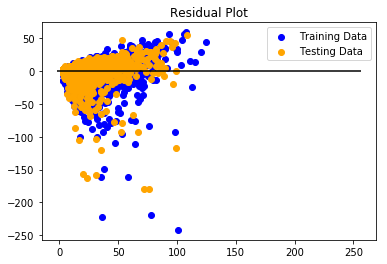

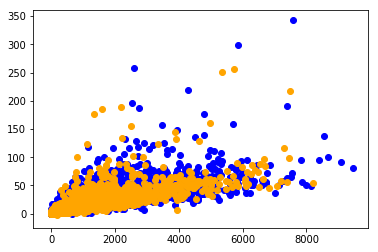

In [44]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import StandardScaler
from scipy.stats import shapiro
import statsmodels.api as sm

X = df1['Sum_Cant piezas'].values.reshape(-1, 1)
y = df1['Lead_Time_x'].values.reshape(-1, 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=4,test_size=.33)

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
model = LinearRegression()
model.fit(X_train, y_train)
predictions = model.predict(X_test)
mse = mean_squared_error(y_test, predictions)
r2 = r2_score(y_test, predictions)
#r2 = r2_score(X_train_scaled, y_train_scaled)
X2_train = sm.add_constant(X_train)
est = sm.OLS(y_train, X2_train)
est2 = est.fit()
residuals = est2.fittedvalues
Error_Frame= pd.DataFrame(residuals)-pd.DataFrame(y_train)

statE, pE = shapiro(Error_Frame) 
stat, p = shapiro(X_train) 

print('Weight coefficients: ', model.coef_)
print('y-axis intercept: ', model.intercept_) 
print(est2.summary())
print('Normality Test of Error Statistics=%.3f, p=%.3f' % (statE, pE) )
print('Normality Test of Error Statistics=%.3f, p=%.3f' % (stat, p) )
print(f"Mean Squared Error (MSE): {mse}")
print(f"R-squared (R2 ): {r2}")
print(X.shape)
print(y.shape)
plt.scatter(model.predict(X_train), model.predict(X_train) - y_train, c="blue", label="Training Data")
plt.scatter(model.predict(X_test), model.predict(X_test) - y_test, c="orange", label="Testing Data")
plt.legend()
plt.hlines(y=0, xmin=y_test.min(), xmax=y_test.max())
plt.title("Residual Plot")
plt.show()
plt.scatter(X_train,y_train, c="blue", label="Training Data")
plt.scatter(X_test,y_test, c="orange", label="Testing Data")

Weight coefficients:  [[0.01280094]]
y-axis intercept:  [2.73008714]
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.555
Model:                            OLS   Adj. R-squared:                  0.555
Method:                 Least Squares   F-statistic:                 1.337e+04
Date:                Tue, 12 Nov 2019   Prob (F-statistic):               0.00
Time:                        10:56:16   Log-Likelihood:                -41411.
No. Observations:               10715   AIC:                         8.283e+04
Df Residuals:                   10713   BIC:                         8.284e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------

C:\Users\pipe_\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1653: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
C:\Users\pipe_\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1653: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


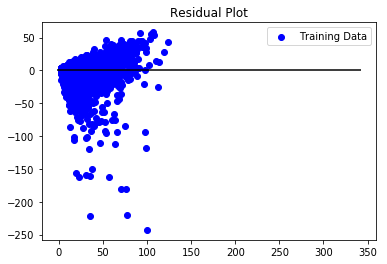

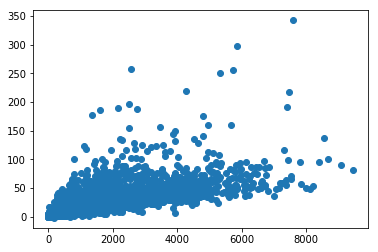

In [45]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
model = LinearRegression()
model.fit(X, y)
predictions = model.predict(X)
print('Weight coefficients: ', model.coef_)
print('y-axis intercept: ', model.intercept_) 
mse = mean_squared_error(y, predictions)
r2 = r2_score(y, predictions)
X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
residuals = est2.fittedvalues
Error_Frame= pd.DataFrame(residuals)-pd.DataFrame(y)
statE, pE = shapiro(Error_Frame) 
stat, p = shapiro(X) 
print(est2.summary())
print('Normality Test of Error Statistics=%.3f, p=%.3f' % (statE, pE) )
print('Normality Test of Error Statistics=%.3f, p=%.3f' % (stat, p) )
print(f"Mean Squared Error (MSE): {mse}")
print(f"R-squared (R2 ): {r2}")
plt.scatter(model.predict(X), model.predict(X) - y, c="blue", label="Training Data")
plt.legend()
plt.hlines(y=0, xmin=y.min(), xmax=y.max())
plt.title("Residual Plot")
plt.show()
plt.scatter(X,y)

Weight coefficients:  [0.01280093]
y-axis intercept:  [2.73009741]
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.555
Model:                            OLS   Adj. R-squared:                  0.555
Method:                 Least Squares   F-statistic:                 1.337e+04
Date:                Tue, 12 Nov 2019   Prob (F-statistic):               0.00
Time:                        11:00:41   Log-Likelihood:                -41411.
No. Observations:               10715   AIC:                         8.283e+04
Df Residuals:                   10713   BIC:                         8.284e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------

C:\Users\pipe_\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1653: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
C:\Users\pipe_\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1653: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


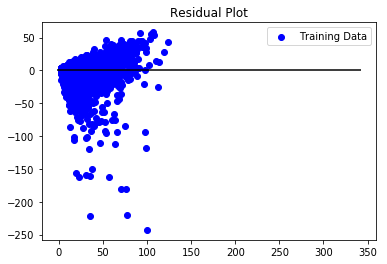

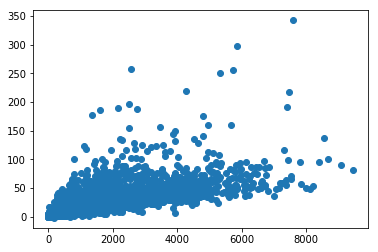

In [46]:
from sklearn.linear_model import Lasso
lasso = Lasso(alpha=.01).fit(X, y)
predictions = lasso.predict(X)
mse = mean_squared_error(y, predictions)
r2 = r2_score(y, predictions)
X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
residuals = est2.fittedvalues
Error_Frame= pd.DataFrame(residuals)-pd.DataFrame(y)
statE, pE = shapiro(Error_Frame) 
stat, p = shapiro(X) 
print('Weight coefficients: ', lasso.coef_)
print('y-axis intercept: ', lasso.intercept_) 
print(est2.summary())
print('Normality Test of Error Statistics=%.3f, p=%.3f' % (statE, pE) )
print('Normality Test of Error Statistics=%.3f, p=%.3f' % (stat, p) )
print(f"Mean Squared Error (MSE): {mse}")
print(f"R-squared (R2 ): {r2}")
plt.scatter(model.predict(X), model.predict(X) - y, c="blue", label="Training Data")
plt.legend()
plt.hlines(y=0, xmin=y.min(), xmax=y.max())
plt.title("Residual Plot")
plt.show()
plt.scatter(X,y)

In [10]:
from sklearn.linear_model import Ridge
ridge = Ridge(alpha=.01).fit(X, y)
predictions = ridge.predict(X)
print('Weight coefficients: ', ridge.coef_)
print('y-axis intercept: ', ridge.intercept_) 
mse = mean_squared_error(y, predictions)
r2 = r2_score(y, predictions)
X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
residuals = est2.fittedvalues
Error_Frame= pd.DataFrame(residuals)-pd.DataFrame(y)
statE, pE = shapiro(Error_Frame) 
stat, p = shapiro(X) 
print(est2.summary())
print('Normality Test of Error Statistics=%.3f, p=%.3f' % (statE, pE) )
print('Normality Test of Error Statistics=%.3f, p=%.3f' % (stat, p) )
print(f"Mean Squared Error (MSE): {mse}")
print(f"R-squared (R2 ): {r2}")

Weight coefficients:  [[0.01280094]]
y-axis intercept:  [2.73008714]
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.555
Model:                            OLS   Adj. R-squared:                  0.555
Method:                 Least Squares   F-statistic:                 1.337e+04
Date:                Tue, 12 Nov 2019   Prob (F-statistic):               0.00
Time:                        10:47:52   Log-Likelihood:                -41411.
No. Observations:               10715   AIC:                         8.283e+04
Df Residuals:                   10713   BIC:                         8.284e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------

C:\Users\pipe_\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1653: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
C:\Users\pipe_\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1653: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


In [11]:
from sklearn.linear_model import ElasticNet
regr = ElasticNet(random_state=0)
regr.fit(X, y) 
predictions = regr.predict(X)
print('Weight coefficients: ', regr.coef_)
print('y-axis intercept: ', regr.intercept_) 
mse = mean_squared_error(y, predictions)
r2 = r2_score(y, predictions)
X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
residuals = est2.fittedvalues
Error_Frame= pd.DataFrame(residuals)-pd.DataFrame(y)
statE, pE = shapiro(Error_Frame) 
stat, p = shapiro(X) 
print(est2.summary())
print('Normality Test of Error Statistics=%.3f, p=%.3f' % (statE, pE) )
print('Normality Test of Error Statistics=%.3f, p=%.3f' % (stat, p) )
print(f"Mean Squared Error (MSE): {mse}")
print(f"R-squared (R2 ): {r2}")

Weight coefficients:  [0.01280044]
y-axis intercept:  [2.73060713]
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.555
Model:                            OLS   Adj. R-squared:                  0.555
Method:                 Least Squares   F-statistic:                 1.337e+04
Date:                Tue, 12 Nov 2019   Prob (F-statistic):               0.00
Time:                        10:47:52   Log-Likelihood:                -41411.
No. Observations:               10715   AIC:                         8.283e+04
Df Residuals:                   10713   BIC:                         8.284e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------

C:\Users\pipe_\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1653: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
C:\Users\pipe_\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1653: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


In [12]:
df1['Mano de Obra'] =((0.01280044*df1['Sum_Cant piezas']+2.73060713)*24/(8))/2
df1.head(5)

,Fin de captura,etie_nomtienda_0,eped_idtipoped_1,Sum_Cant piezas,Lead_Time_x,Lead_Time_y,Mano de Obra
0,2019-08-30,5 DE FEBRERO NORTE,114,39,4.844444,0.463304,4.844736
1,2019-08-31,5 DE FEBRERO NORTE,662,336,6.090278,0.463304,10.547332
2,2019-09-01,5 DE FEBRERO NORTE,2089,952,10.590278,0.463304,22.374939
3,2019-09-02,5 DE FEBRERO NORTE,2490,894,11.257639,0.463304,21.261301
4,2019-09-03,5 DE FEBRERO NORTE,1868,899,9.892361,0.463304,21.357304


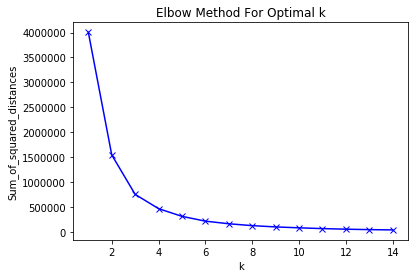

In [13]:
from sklearn.cluster import KMeans
Y=df1['Mano de Obra'].values.reshape(-1, 1)
Sum_of_squared_distances = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(Y)
    Sum_of_squared_distances.append(km.inertia_)
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

[[12.25126637]
 [99.12859199]
 [51.15479409]
 [27.26299804]]
(10715,)
  Fin de captura    etie_nomtienda_0  eped_idtipoped_1  Sum_Cant piezas  \
0     2019-08-30  5 DE FEBRERO NORTE               114               39   
1     2019-08-31  5 DE FEBRERO NORTE               662              336   
2     2019-09-01  5 DE FEBRERO NORTE              2089              952   
3     2019-09-02  5 DE FEBRERO NORTE              2490              894   
4     2019-09-03  5 DE FEBRERO NORTE              1868              899   

   Lead_Time_x  Lead_Time_y  Mano de Obra   Clasifica2   
0     4.844444     0.463304      4.844736             0  
1     6.090278     0.463304     10.547332             0  
2    10.590278     0.463304     22.374939             3  
3    11.257639     0.463304     21.261301             3  
4     9.892361     0.463304     21.357304             3  


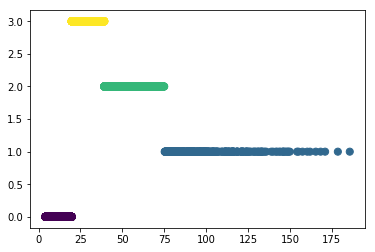

In [14]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=4)
kmeans.fit(Y)
predicted_clusters = kmeans.predict(Y)
centers = kmeans.cluster_centers_
labels = kmeans.labels_
import numpy as np
labels = np.array(labels)
plt.scatter(Y[:, 0], labels, c=predicted_clusters, s=50, cmap='viridis')
print(centers)
print(labels.shape)
from sklearn.metrics import classification_report
import sys
np.set_printoptions(threshold=sys.maxsize)
df1[' Clasifica2 ']=labels
export_csv = df1.to_csv (r'DailyRegression.csv', index = None, header=True)
print(df1.head(5))

In [15]:
import pandas as pd
import numpy as np
dfz = pd.read_csv('Pedidos con piezas.csv')
df1a=dfz
df2b=dfz
df3c=dfz
dfa=dfz
dfz['Fin de captura'] = pd.to_datetime(dfz['Fin de captura'], format= '%d/%m/%Y %H:%M')
dfz['Fecha de entrega'] = pd.to_datetime(dfz['Fecha de entrega'], format= '%d/%m/%Y %H:%M')
dfz["Lead_Time"]=dfz["Fecha de entrega"]-dfz["Fin de captura"]
dfz['Lead_Time'] = dfz['Lead_Time'].dt.total_seconds() / (24 * 60 * 60)
pd.set_option('display.max_columns', None)
dfz.head(5)

,ID pedido,Det,etie_nomtienda_0,eped_idtipoped_1,Fecha de entrega,Fin de captura,Venta Neta,Sum_Cant piezas,Lead_Time
0,28076671,1003,PLAYA DEL CARMEN,11,2019-10-28 12:00:00,2019-10-27 11:05:00,832.51,594,1.038194
1,27504186,1003,PLAYA DEL CARMEN,11,2019-09-10 13:00:00,2019-09-06 16:57:00,655.24,503,3.835417
2,27612964,1003,PLAYA DEL CARMEN,103,2019-09-19 14:00:00,2019-09-19 10:53:00,7507.84,190,0.129861
3,27462663,1003,PLAYA DEL CARMEN,103,2019-09-06 13:00:00,2019-09-04 20:09:00,7099.74,188,1.702083
4,28232574,1003,PLAYA DEL CARMEN,11,2019-11-05 09:00:00,2019-11-04 17:13:00,5272.92,176,0.657639


In [16]:
from datetime import timedelta, date, datetime
df1a['Fin de captura'] = pd.to_datetime(df1a['Fin de captura'], format= '%d/%m/%Y %H:%M')
df1a['Fecha de entrega'] = pd.to_datetime(df1a['Fecha de entrega'], format= '%d/%m/%Y %H:%M')
df1a["Lead_Time"]=df1a["Fecha de entrega"]-df1a["Fin de captura"]
df1a['Lead_Time'] = df1a['Lead_Time'].dt.total_seconds() / (24 * 60 * 60)
df1a = df1a.drop(columns=["Det", "ID pedido", "Sum_Cant piezas", "Venta Neta","Fecha de entrega","eped_idtipoped_1"])
df1a=df1a.set_index('Fin de captura').groupby([pd.Grouper(freq='8H'), 'etie_nomtienda_0']).mean()
df1a=df1a.sort_values(['etie_nomtienda_0'], ascending=[True])
df1a=df1a.sort_values(['etie_nomtienda_0', 'Fin de captura'], ascending=[True, True])
df1a.head(5)

,,Lead_Time
Fin de captura,etie_nomtienda_0,
2019-08-30 00:00:00,5 DE FEBRERO NORTE,3.184722
2019-08-30 16:00:00,5 DE FEBRERO NORTE,1.659722
2019-08-31 08:00:00,5 DE FEBRERO NORTE,0.870139
2019-08-31 16:00:00,5 DE FEBRERO NORTE,0.580015
2019-09-01 00:00:00,5 DE FEBRERO NORTE,0.331944


In [17]:
df2b['Fin de captura'] = pd.to_datetime(df2b['Fin de captura'], format= '%d/%m/%Y %H:%M')
df2b['Fecha de entrega'] = pd.to_datetime(df2b['Fecha de entrega'], format= '%d/%m/%Y %H:%M')
df2b["Lead_Time"]=df2b["Fecha de entrega"]-df2b["Fin de captura"]
df2b['Lead_Time'] = df2b['Lead_Time'].dt.total_seconds() / (24 * 60 * 60)
df2b = df2b.drop(columns=["Det", "ID pedido", "Sum_Cant piezas", "Venta Neta","Fecha de entrega","eped_idtipoped_1"])
df2b=df2b.set_index('Fin de captura').groupby([pd.Grouper(freq='8H'), 'etie_nomtienda_0']).apply(np.std)
df2b=df2b.sort_values(['etie_nomtienda_0'], ascending=[True])
df2b=df2b.sort_values(['etie_nomtienda_0', 'Fin de captura'], ascending=[True, True])
df2b.head(5)

,,Lead_Time
Fin de captura,etie_nomtienda_0,
2019-08-30 00:00:00,5 DE FEBRERO NORTE,0.000000
2019-08-30 16:00:00,5 DE FEBRERO NORTE,0.000000
2019-08-31 08:00:00,5 DE FEBRERO NORTE,0.000000
2019-08-31 16:00:00,5 DE FEBRERO NORTE,0.107466
2019-09-01 00:00:00,5 DE FEBRERO NORTE,0.000000


In [18]:
df3c['Fin de captura'] = pd.to_datetime(df3c['Fin de captura'], format= '%d/%m/%Y %H:%M')
df3c['Fecha de entrega'] = pd.to_datetime(df3c['Fecha de entrega'], format= '%d/%m/%Y %H:%M')
df3c["Lead_Time"]=df3c["Fecha de entrega"]-df3c["Fin de captura"]
df3c['Lead_Time'] = df3c['Lead_Time'].dt.total_seconds() / (24 * 60 * 60)
df3c = df3c.drop(columns=["Det", "ID pedido", "Sum_Cant piezas", "Venta Neta","Fecha de entrega","eped_idtipoped_1"])
df3c=df3c.set_index('Fin de captura').groupby([pd.Grouper(freq='8H'), 'etie_nomtienda_0']).count()
df3c=df3c.sort_values(['etie_nomtienda_0'], ascending=[True])
df3c=df3c.sort_values(['etie_nomtienda_0', 'Fin de captura'], ascending=[True, True])
df3c.head(5)

,,Lead_Time
Fin de captura,etie_nomtienda_0,
2019-08-30 00:00:00,5 DE FEBRERO NORTE,1
2019-08-30 16:00:00,5 DE FEBRERO NORTE,1
2019-08-31 08:00:00,5 DE FEBRERO NORTE,1
2019-08-31 16:00:00,5 DE FEBRERO NORTE,9
2019-09-01 00:00:00,5 DE FEBRERO NORTE,1


In [19]:
from scipy.stats import norm
df5e=df1a+norm.ppf(0.95)*df2b.div(df3c**(1/2),axis=0)
df5e = df5e.reset_index()
def hr_func(ts):
    return ts.hour
df5e['Fin de captura']= df5e['Fin de captura'].apply(hr_func)
df5e=df5e.sort_values(['etie_nomtienda_0'], ascending=[True])
df5e=df5e.sort_values(['etie_nomtienda_0', 'Fin de captura'], ascending=[True, True])
df6f=df5e
df7g=df5e
df8h=df5e
print(df5e.head(5))

     Fin de captura    etie_nomtienda_0  Lead_Time
0                 0  5 DE FEBRERO NORTE   3.184722
122               0  5 DE FEBRERO NORTE   0.363889
125               0  5 DE FEBRERO NORTE   0.451889
128               0  5 DE FEBRERO NORTE   0.134028
136               0  5 DE FEBRERO NORTE   1.247814


In [20]:
df6f =df6f.set_index('Fin de captura').groupby(['etie_nomtienda_0','Fin de captura']).apply(np.mean)
print(df6f.head(10))

                                   Lead_Time
etie_nomtienda_0   Fin de captura           
5 DE FEBRERO NORTE 0                0.748919
                   8                0.340475
                   16               0.714722
ACAPULCO           0                0.591623
                   8                0.382542
                   16               0.668601
ACAPULCO DIAMANTE  0                0.564763
                   8                0.560678
                   16               0.846574
AEROPUERTO         0                0.576211


In [21]:
df7g =df7g.set_index('Fin de captura').groupby([ 'etie_nomtienda_0','Fin de captura']).apply(np.std)
print(df7g.head(10))

                                   Lead_Time
etie_nomtienda_0   Fin de captura           
5 DE FEBRERO NORTE 0                0.621572
                   8                0.173662
                   16               0.218936
ACAPULCO           0                0.730729
                   8                0.165098
                   16               0.215076
ACAPULCO DIAMANTE  0                0.591401
                   8                0.541284
                   16               0.514199
AEROPUERTO         0                0.334301


In [22]:
df8h =df8h.set_index('Fin de captura').groupby([ 'etie_nomtienda_0','Fin de captura']).count()
print(df8h.head(10))

                                   Lead_Time
etie_nomtienda_0   Fin de captura           
5 DE FEBRERO NORTE 0                      56
                   8                      67
                   16                     67
ACAPULCO           0                      52
                   8                      67
                   16                     66
ACAPULCO DIAMANTE  0                      51
                   8                      67
                   16                     67
AEROPUERTO         0                      68


In [23]:
df9i=df6f+norm.ppf(0.95)*df7g.div(df8h**(1/2),axis=0)
print(df9i.head(10))

                                   Lead_Time
etie_nomtienda_0   Fin de captura           
5 DE FEBRERO NORTE 0                0.885543
                   8                0.375372
                   16               0.758717
ACAPULCO           0                0.758302
                   8                0.415718
                   16               0.712147
ACAPULCO DIAMANTE  0                0.700978
                   8                0.669450
                   16               0.949902
AEROPUERTO         0                0.642893


In [24]:
from datetime import timedelta, date, datetime
dfa=dfz
dfa['Fin de captura'] = pd.to_datetime(dfa['Fin de captura'], format= '%d/%m/%Y %H:%M')
dfa['Fecha de entrega'] = pd.to_datetime(dfa['Fecha de entrega'], format= '%d/%m/%Y %H:%M')
dfa = dfa.drop(columns=["Det", "ID pedido", "Venta Neta","Fecha de entrega","eped_idtipoped_1"])
dfa=dfa.set_index('Fin de captura').groupby([pd.Grouper(freq='8H'), 'etie_nomtienda_0']).sum()
dfa=dfa.sort_values(['etie_nomtienda_0', 'Fin de captura'], ascending=[True, True])
print(dfa.head())
X = dfa['Sum_Cant piezas'].values.reshape(-1, 1)
y = dfa['Lead_Time'].values.reshape(-1, 1)
model = LinearRegression()
model.fit(X, y)
predictions = model.predict(X)
print('Weight coefficients: ', model.coef_)
print('y-axis intercept: ', model.intercept_) 
mse = mean_squared_error(y, predictions)
r2 = r2_score(y, predictions)
X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
residuals = est2.fittedvalues
Error_Frame= pd.DataFrame(residuals)-pd.DataFrame(y)
statE, pE = shapiro(Error_Frame) 
stat, p = shapiro(X) 
print(est2.summary())
print('Normality Test of Error Statistics=%.3f, p=%.3f' % (statE, pE) )
print('Normality Test of Error Statistics=%.3f, p=%.3f' % (stat, p) )
print(f"Mean Squared Error (MSE): {mse}")
print(f"R-squared (R2 ): {r2}")

                                        Sum_Cant piezas  Lead_Time
Fin de captura      etie_nomtienda_0                              
2019-08-30 00:00:00 5 DE FEBRERO NORTE                4   3.184722
2019-08-30 16:00:00 5 DE FEBRERO NORTE               35   1.659722
2019-08-31 08:00:00 5 DE FEBRERO NORTE               39   0.870139
2019-08-31 16:00:00 5 DE FEBRERO NORTE              297   5.220139
2019-09-01 00:00:00 5 DE FEBRERO NORTE               35   0.331944
Weight coefficients:  [[0.01143866]]
y-axis intercept:  [1.51805109]
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.457
Model:                            OLS   Adj. R-squared:                  0.457
Method:                 Least Squares   F-statistic:                 2.462e+04
Date:                Tue, 12 Nov 2019   Prob (F-statistic):               0.00
Time:                        10:48:34   Log-Likelihood:            

C:\Users\pipe_\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1653: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
C:\Users\pipe_\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1653: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


In [25]:
from datetime import timedelta, date, datetime
dfa=dfz
dfa['Fin de captura'] = pd.to_datetime(dfa['Fin de captura'], format= '%d/%m/%Y %H:%M')
dfa['Fecha de entrega'] = pd.to_datetime(dfa['Fecha de entrega'], format= '%d/%m/%Y %H:%M')
dfa = dfa.drop(columns=["Det", "ID pedido", "Venta Neta","Fecha de entrega","eped_idtipoped_1"])
dfa=dfa.set_index('Fin de captura').groupby([pd.Grouper(freq='8H'), 'etie_nomtienda_0']).mean()
dfa=dfa.sort_values(['etie_nomtienda_0', 'Fin de captura'], ascending=[True, True])
print(dfa.head())

                                        Sum_Cant piezas  Lead_Time
Fin de captura      etie_nomtienda_0                              
2019-08-30 00:00:00 5 DE FEBRERO NORTE              4.0   3.184722
2019-08-30 16:00:00 5 DE FEBRERO NORTE             35.0   1.659722
2019-08-31 08:00:00 5 DE FEBRERO NORTE             39.0   0.870139
2019-08-31 16:00:00 5 DE FEBRERO NORTE             33.0   0.580015
2019-09-01 00:00:00 5 DE FEBRERO NORTE             35.0   0.331944


In [26]:
dfa = dfa.reset_index()
def hr_func(ts):
    return ts.hour
dfa['Fin de captura']= dfa['Fin de captura'].apply(hr_func)
dfa=dfa.sort_values(['etie_nomtienda_0'], ascending=[True])
dfa=dfa.sort_values(['etie_nomtienda_0', 'Fin de captura'], ascending=[True, True])
dfa.head(5)

,Fin de captura,etie_nomtienda_0,Sum_Cant piezas,Lead_Time
0,0,5 DE FEBRERO NORTE,4.0,3.184722
122,0,5 DE FEBRERO NORTE,8.0,0.363889
125,0,5 DE FEBRERO NORTE,9.5,0.294792
128,0,5 DE FEBRERO NORTE,11.0,0.134028
136,0,5 DE FEBRERO NORTE,11.0,0.857292


In [27]:
dfa =dfa.set_index('Fin de captura').groupby(['etie_nomtienda_0','Fin de captura']).mean()
dfa.head(5)

Sum_Cant piezas  Lead_Time
etie_nomtienda_0   Fin de captura                            
5 DE FEBRERO NORTE 0                     23.995861   0.561723
                   8                     24.917360   0.256125
                   16                    30.985737   0.592732
ACAPULCO           0                     36.504686   0.421983
                   8                     26.070928   0.289303

In [28]:
dfa['Mano de Obra'] =((0.01280044*dfa['Sum_Cant piezas']+2.73060713)*24/(8))/2
dfa = pd.merge(left=dfa,right=df9i,on=['etie_nomtienda_0', 'Fin de captura'])
dfa.head(5)

Sum_Cant piezas  Lead_Time_x  Mano de Obra  \
etie_nomtienda_0   Fin de captura                                               
5 DE FEBRERO NORTE 0                     23.995861     0.561723      4.556647   
                   8                     24.917360     0.256125      4.574340   
                   16                    30.985737     0.592732      4.690857   
ACAPULCO           0                     36.504686     0.421983      4.796825   
                   8                     26.070928     0.289303      4.596490   

                                   Lead_Time_y  
etie_nomtienda_0   Fin de captura               
5 DE FEBRERO NORTE 0                  0.885543  
                   8                  0.375372  
                   16                 0.758717  
ACAPULCO           0                  0.758302  
                   8                  0.415718

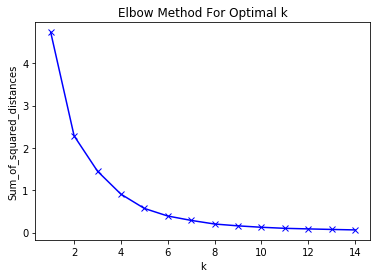

In [29]:
from sklearn.cluster import KMeans
Ya=dfa['Mano de Obra'].values.reshape(-1, 1)
Sum_of_squared_distances = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(Ya)
    Sum_of_squared_distances.append(km.inertia_)
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()


[[4.618269  ]
 [4.48962559]
 [5.25247608]
 [4.72490731]]
(477,)
[0 0 3 3 0 3 0 0 3 3 0 0 3 0 0 0 1 1 3 0 0 3 3 3 1 1 1 0 0 3 0 0 0 3 0 0 3
 0 0 0 0 0 3 0 0 0 3 0 3 0 0 0 0 0 3 0 0 0 3 3 1 1 1 3 3 0 0 3 1 3 0 0 0 1
 1 1 0 0 3 0 0 0 0 0 3 0 0 1 1 1 1 1 1 3 3 3 3 3 3 0 0 3 0 0 0 3 0 0 3 0 0
 0 0 0 3 1 1 0 0 3 3 0 3 1 1 1 0 0 0 1 1 1 3 3 3 0 3 0 3 1 1 0 0 3 3 1 1 3
 3 3 3 0 0 1 0 1 3 2 3 3 1 0 0 3 3 1 1 1 0 1 1 0 0 0 3 0 3 3 0 0 3 3 0 0 0
 0 0 3 0 0 0 0 1 0 1 3 3 3 0 0 1 0 0 1 3 0 0 0 0 3 1 0 0 0 3 3 3 3 3 3 0 3
 3 0 0 0 0 0 0 1 0 1 1 0 1 1 1 0 0 0 0 1 1 3 3 3 3 0 0 0 0 0 0 3 0 0 0 0 3
 0 3 1 1 1 0 0 1 0 0 0 0 0 1 3 3 3 0 0 0 3 0 3 3 3 3 3 0 3 3 0 0 0 0 0 3 0
 3 0 1 0 0 3 3 0 0 0 0 0 0 3 0 0 3 0 3 0 0 1 0 1 1 0 0 0 0 3 0 0 0 3 1 1 1
 3 3 0 3 3 3 3 3 0 1 1 0 3 0 3 0 3 0 0 0 0 3 0 0 0 1 1 0 0 3 0 0 0 0 0 0 0
 0 1 0 0 0 2 0 0 1 1 0 0 3 0 3 0 3 0 0 0 0 0 0 0 1 1 1 0 0 1 0 3 3 3 3 1 1
 0 1 1 0 1 0 0 3 3 3 0 0 0 1 0 1 0 1 1 3 0 3 0 0 0 0 0 0 3 0 3 1 1 1 1 0 1
 3 0 0 0 1 0 1 0 0 3 3 3 0 0 0 3 0 0

,etie_nomtienda_0,Fin de captura,Sum_Cant piezas,Lead_Time_x,Mano de Obra,Lead_Time_y,Clasifica2,Horas Estimadas Para Entregar
0,5 DE FEBRERO NORTE,0,23.995861,0.561723,4.556647,0.885543,0,21.253025
1,5 DE FEBRERO NORTE,8,24.917360,0.256125,4.574340,0.375372,0,17.008928
2,5 DE FEBRERO NORTE,16,30.985737,0.592732,4.690857,0.758717,3,34.209217
3,ACAPULCO,0,36.504686,0.421983,4.796825,0.758302,3,18.199245
4,ACAPULCO,8,26.070928,0.289303,4.596490,0.415718,0,17.977243


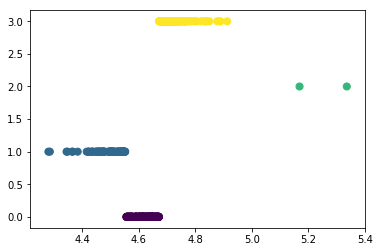

In [30]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=4)
kmeans.fit(Ya)
predicted_clusters = kmeans.predict(Ya)
centers = kmeans.cluster_centers_
labels = kmeans.labels_
import numpy as np
labels = np.array(labels)
plt.scatter(Ya[:, 0], labels, c=predicted_clusters, s=50, cmap='viridis')
#plt.show()
print(centers)
print(labels.shape)
from sklearn.metrics import classification_report
import sys
np.set_printoptions(threshold=sys.maxsize)
print(labels)
dfa[' Clasifica2 ']=labels
dfa = dfa.reset_index()
dfa['Horas Estimadas Para Entregar']=dfa['Fin de captura']+dfa['Lead_Time_y']*24
export_csv = dfa.to_csv (r'RegressionByLifts.csv', index = True, header=True)
dfa.head(5)

In [31]:
X = dfa['Sum_Cant piezas'].values.reshape(-1, 1)
y = dfa['Lead_Time_x'].values.reshape(-1, 1)
model = LinearRegression()
model.fit(X, y)
predictions = model.predict(X)
print('Weight coefficients: ', model.coef_)
print('y-axis intercept: ', model.intercept_) 
mse = mean_squared_error(y, predictions)
r2 = r2_score(y, predictions)
X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
residuals = est2.fittedvalues
Error_Frame= pd.DataFrame(residuals)-pd.DataFrame(y)
statE, pE = shapiro(Error_Frame) 
stat, p = shapiro(X) 
print(est2.summary())
print('Normality Test of Error Statistics=%.3f, p=%.3f' % (statE, pE) )
print('Normality Test of Error Statistics=%.3f, p=%.3f' % (stat, p) )
print(f"Mean Squared Error (MSE): {mse}")
print(f"R-squared (R2 ): {r2}")

Weight coefficients:  [[0.00253018]]
y-axis intercept:  [0.39575456]
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     2.763
Date:                Tue, 12 Nov 2019   Prob (F-statistic):             0.0972
Time:                        10:48:35   Log-Likelihood:                 162.56
No. Observations:                 477   AIC:                            -321.1
Df Residuals:                     475   BIC:                            -312.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------

In [32]:
import datetime as dt
df00 = pd.read_csv('asociados x hora.csv',parse_dates=['Fecha'], dayfirst=True)
df00['Date'] = pd.to_datetime(df00['Fecha'].apply(str)+' '+df00['Hora de entrada'])
df00['Date'] = pd.to_datetime(df00['Date'], format= '%d/%m/%Y %H:%M:%S')

df00=df00.set_index('Date').groupby([pd.Grouper(freq='8H'), 'etie_nomtienda_0']).mean()
df00.reset_index(drop=False, inplace=True)
def hr_func(ts):
    return ts.hour
df00['Fin de captura']= df00['Date'].apply(hr_func)
df00=df00.sort_values(['etie_nomtienda_0'], ascending=[True])
df00=df00.sort_values(['etie_nomtienda_0', 'Fin de captura'], ascending=[True, True])
pd.set_option('display.max_rows', None)
df00.head(5)

,Date,etie_nomtienda_0,Determinante,Asociados por hora,Fin de captura
0,2019-08-01,0,2944.61039,0.0,0
3186,2019-08-10,0,2944.61039,0.0,0
22833,2019-10-07,0,2944.61039,0.0,0
23187,2019-10-08,0,2944.61039,0.0,0
23541,2019-10-09,0,2944.61039,0.0,0


In [33]:
df01=dfa[['Fin de captura','etie_nomtienda_0','Mano de Obra']]
df01.reset_index(drop=False, inplace=True)
df01 = pd.merge(df01,df00, how='inner', on=['etie_nomtienda_0', 'Fin de captura'])
df01=df01.sort_values(['etie_nomtienda_0'], ascending=[True])
df01=df01.sort_values(['etie_nomtienda_0', 'Fin de captura', 'Date'], ascending=[True, True, True])
df01.head(5)

,index,Fin de captura,etie_nomtienda_0,Mano de Obra,Date,Determinante,Asociados por hora
75,3,0,ACAPULCO,4.796825,2019-08-01,2349.0,1.250
66,3,0,ACAPULCO,4.796825,2019-08-02,2349.0,0.875
12,3,0,ACAPULCO,4.796825,2019-08-03,2349.0,1.125
41,3,0,ACAPULCO,4.796825,2019-08-04,2349.0,1.250
60,3,0,ACAPULCO,4.796825,2019-08-05,2349.0,1.000


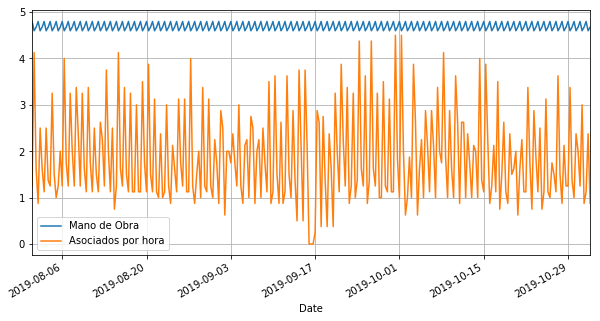

In [47]:
df01.loc[df01['etie_nomtienda_0']=='ACAPULCO'].plot(x='Date', y=['Mano de Obra', 'Asociados por hora'], figsize=(10,5),
                                                    grid=True)

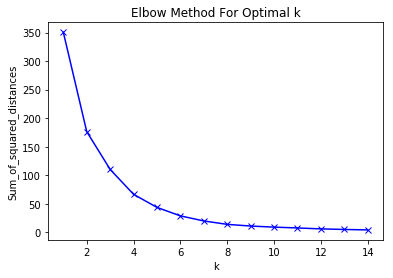

In [35]:
from sklearn.cluster import KMeans
Y01=df01['Mano de Obra'].values.reshape(-1, 1)
Sum_of_squared_distances = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(Y01)
    Sum_of_squared_distances.append(km.inertia_)
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

[[4.62975351]
 [4.49936304]
 [4.74211998]
 [5.24920714]]
(31758,)


,index,Fin de captura,etie_nomtienda_0,Mano de Obra,Date,Determinante,Asociados por hora,Clasifica2
75,3,0,ACAPULCO,4.796825,2019-08-01,2349.0,1.250,2
66,3,0,ACAPULCO,4.796825,2019-08-02,2349.0,0.875,2
12,3,0,ACAPULCO,4.796825,2019-08-03,2349.0,1.125,2
41,3,0,ACAPULCO,4.796825,2019-08-04,2349.0,1.250,2
60,3,0,ACAPULCO,4.796825,2019-08-05,2349.0,1.000,2


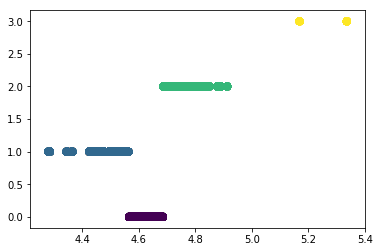

In [50]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=4)
kmeans.fit(Y01)
predicted_clusters = kmeans.predict(Y01)
centers = kmeans.cluster_centers_
labels = kmeans.labels_
import numpy as np
labels = np.array(labels)
plt.scatter(Y01[:, 0], labels, c=predicted_clusters, s=50, cmap='viridis')
print(centers)
print(labels.shape)
from sklearn.metrics import classification_report
import sys
np.set_printoptions(threshold=sys.maxsize)
df01[' Clasifica2 ']=labels
export_csv = df01.to_csv (r'RegressionByLiftsAsoc.csv', index = True, header=True)
df01.head(5)

In [51]:
df03 = df01
df03.reset_index(drop=True)
df03 = df03.rename(columns={"Date": "datetime", "etie_nomtienda_0": "branch", "Fin de captura": "shift",
                            "Mano de Obra": "fcst_employee",  " Clasifica2 ": "volumen",  
                            "Asociados por hora": "real_employee"})
df03 = df03[["datetime","branch","shift","fcst_employee","volumen","real_employee"]]
print(df03.head(5))
df03.to_json("consolidated_json.js", orient="records")

     datetime    branch  shift  fcst_employee  volumen  real_employee
75 2019-08-01  ACAPULCO      0       4.796825        2          1.250
66 2019-08-02  ACAPULCO      0       4.796825        2          0.875
12 2019-08-03  ACAPULCO      0       4.796825        2          1.125
41 2019-08-04  ACAPULCO      0       4.796825        2          1.250
60 2019-08-05  ACAPULCO      0       4.796825        2          1.000
